In [1]:
#Spacy org
#!pip install spacy
#!python3 -m spacy download en_core_web_sm
#!python3 -m spacy download en_core_web_md
#!python3 -m spacy download en_core_web_lg

In [2]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import yellowbrick

parameters = {'axes.labelsize': 25,
          'axes.titlesize': 35,
             'xtick.labelsize':20,
             "figure.figsize" : (20, 10)
             }


plt.rcParams.update(parameters)

df_overview = pd.read_csv("./Data/processed/Telehealth.csv")

/Users/adamgoldstein/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [3]:
import spacy

corpus = df_overview["Content"]

nlp = spacy.load("en_core_web_sm")

docs = list(nlp.pipe(corpus,disable=["parser","textcat"]))

In [4]:

ner_dictionary = dict()

ner_dictionary_count = dict()

ner_dictionary_document = dict()

#NER token with label
for index, doc in enumerate(docs):
    
    for ent in doc.ents:

        ner_dictionary[ent.text] = ent.label_

        #ner_dictionary_document[ent.text]  (ent.text,index)

        if ent.text in ner_dictionary_count.keys():
            ner_dictionary_count[ent.text] += 1
            ner_dictionary_document[ent.text].add(str(index))

        else:
            ner_dictionary_count[ent.text] = 1
            ner_dictionary_document[ent.text] = {str(index)}

In [5]:
with open("./references/abbreviation_table_processed.json", "r") as r:
    
    abrv_dict = json.load(r)

#drop incorrect abbreviations
#with open('./references/Incorrect_abbrev.json', "r") as toremove:
#    data = json.load(toremove)

#for key in data.keys():
#    abrv_dict.pop(key)

In [6]:
ner_data = [ner_dictionary,ner_dictionary_count,ner_dictionary_document]
df_ner = (pd.DataFrame(ner_data)
          .T
          .reset_index()
          .rename(columns={"index":"Term",0:"NER_Label",1:"Count",2:"Document"})
         .sort_values(by="Count",ascending=False))

In [7]:
df_ner.head(5)

,Term,NER_Label,Count,Document
3061,TMH,ORG,293,"{38, 31, 32, 33, 35, 36}"
154,2020,DATE,271,"{4, 5, 8, 2, 34, 6, 1, 27, 7, 29, 9, 28, 13, 1..."
22,2013,DATE,236,"{0, 41, 4, 5, 8, 2, 34, 24, 6, 42, 1, 27, 37, ..."
30,2018,DATE,233,"{0, 4, 5, 8, 2, 34, 6, 26, 1, 27, 7, 20, 9, 35..."
34,2015,DATE,231,"{0, 41, 5, 8, 2, 34, 24, 6, 42, 1, 27, 37, 7, ..."


In [8]:
df_ner["Long_Form"] = df_ner["Term"].apply(lambda x: abrv_dict[x]["LongForm"] if x in abrv_dict.keys() else x)

df_ner.head(5)

,Term,NER_Label,Count,Document,Long_Form
3061,TMH,ORG,293,"{38, 31, 32, 33, 35, 36}",telemental health
154,2020,DATE,271,"{4, 5, 8, 2, 34, 6, 1, 27, 7, 29, 9, 28, 13, 1...",2020
22,2013,DATE,236,"{0, 41, 4, 5, 8, 2, 34, 24, 6, 42, 1, 27, 37, ...",2013
30,2018,DATE,233,"{0, 4, 5, 8, 2, 34, 6, 26, 1, 27, 7, 20, 9, 35...",2018
34,2015,DATE,231,"{0, 41, 5, 8, 2, 34, 24, 6, 42, 1, 27, 37, 7, ...",2015


In [9]:
df_ner[df_ner["Term"] == "Zoom"]

,Term,NER_Label,Count,Document,Long_Form
632,Zoom,PERSON,17,"{4, 32, 5, 2, 15, 17, 11}",Zoom


In [10]:
#Change Zoom from PERSON to ORG 
df_ner.at[632,"NER_Label"] = "ORG"

In [11]:
df_ner_exploded = df_ner.explode('Document').astype({"Document":"int64"}).drop(columns="Count")
df_ner_exploded.head()

,Term,NER_Label,Document,Long_Form
3061,TMH,ORG,38,telemental health
3061,TMH,ORG,31,telemental health
3061,TMH,ORG,32,telemental health
3061,TMH,ORG,33,telemental health
3061,TMH,ORG,35,telemental health


# Modify NER Classification

In [12]:
entity_by_document_overview = df_ner_exploded.merge(df_overview,left_on="Document",right_on=df_overview.index)

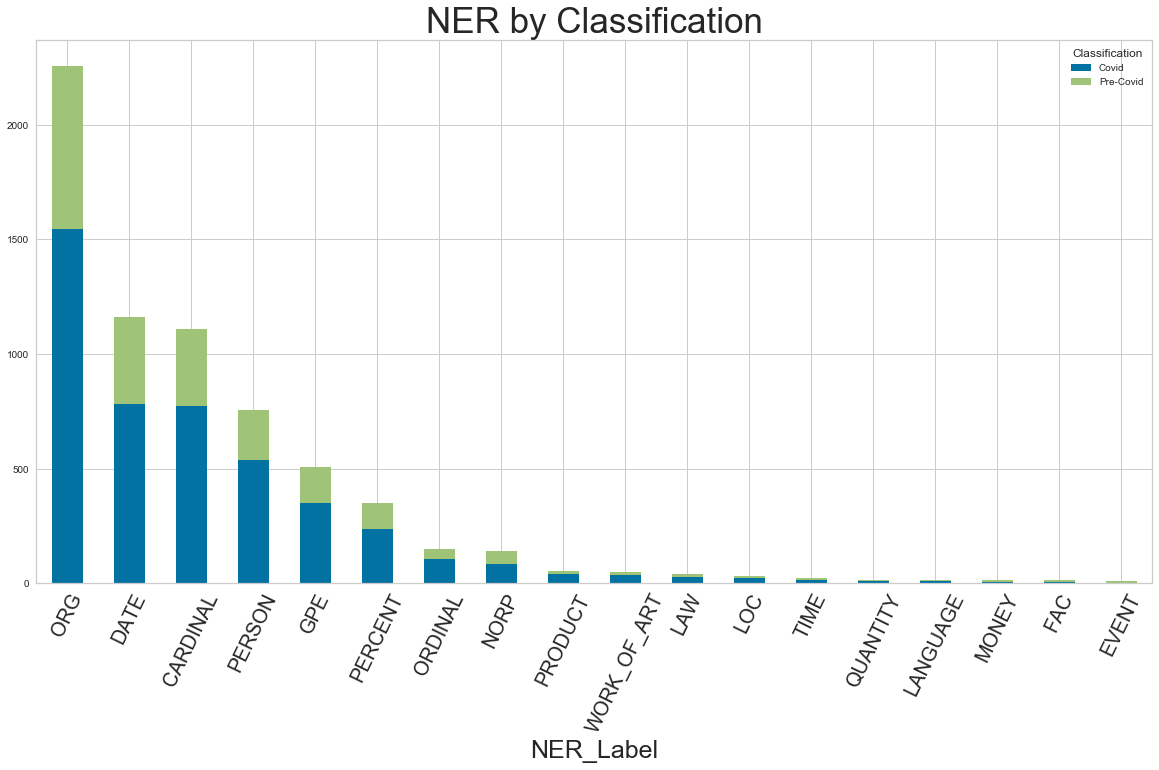

In [13]:
ner_overview_plot = (entity_by_document_overview.groupby(['Classification', 'NER_Label']).size().reset_index()
           .pivot(columns='Classification', index='NER_Label', values=0)
           .sort_values(by="Covid",ascending=False))

ner_overview_plot.plot(kind='bar', stacked=True,title="NER by Classification")
_ = plt.xticks(rotation=64)

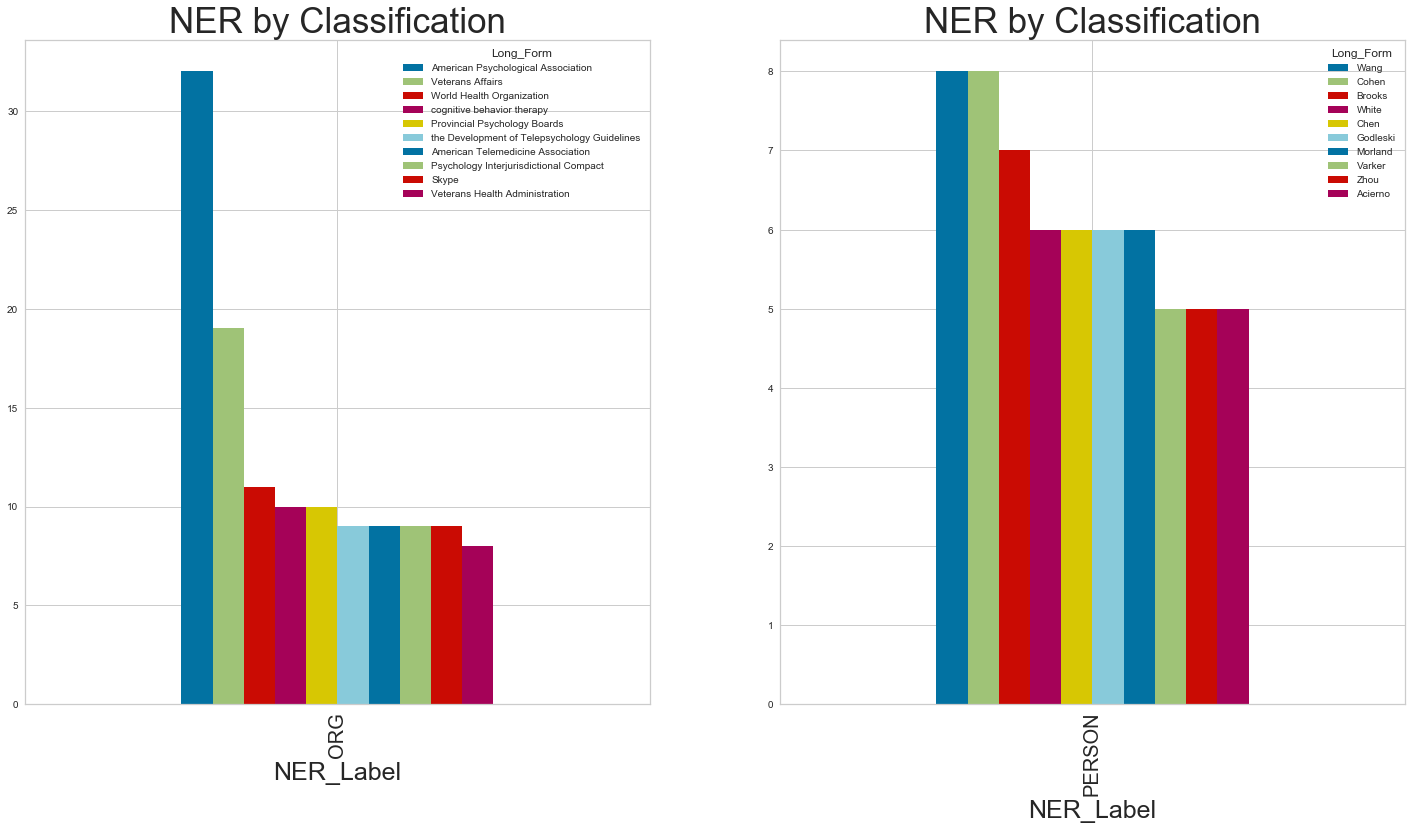

In [14]:
top = 10

visualize_cols = ["ORG","PERSON"]

fig, ax = plt.subplots(1,len(visualize_cols))
fig.tight_layout(h_pad=2,w_pad=8)

for index,col in enumerate(visualize_cols):

    dataset = entity_by_document_overview.query(f'NER_Label == "{col}"')

    ner_overview_plot = (dataset.groupby(['Long_Form', 'NER_Label']).size().reset_index()
                         
                .pivot(columns='NER_Label', index='Long_Form', values=0)
                         
                 .sort_values(by=col,ascending=False)
                         
                 .head(top)
                .T
                )

    ner_overview_plot.plot(kind='bar',title="NER by Classification",ax=ax[index])

In [15]:
pre_covid = (entity_by_document_overview
             .query('Classification == "Pre-Covid" & (NER_Label == "ORG" |NER_Label == "PERSON"|NER_Label == "PRODUCT")'))


pre_covid_plot = (pre_covid[["NER_Label","Long_Form","Term","Document"]]
                  .groupby(["NER_Label","Long_Form"])
                  .count()
                  .sort_values(by="Document",ascending=False)
                  .rename(columns={"Document":"Pre-Covid"})
                  .reset_index()
                 
                 
                 )

In [16]:
pre_covid_plot["Classification"] = "Pre-Covid"
pre_covid_plot.head()

,NER_Label,Long_Form,Term,Pre-Covid,Classification
0,ORG,American Psychological Association,8,8,Pre-Covid
1,ORG,Veterans Affairs,6,6,Pre-Covid
2,ORG,Psychology Interjurisdictional Compact,4,4,Pre-Covid
3,ORG,Provincial Psychology Boards,3,3,Pre-Covid
4,ORG,Skype,3,3,Pre-Covid


In [17]:
post_covid = (entity_by_document_overview
              .query('Classification == "Covid" & (NER_Label == "ORG" |NER_Label == "PERSON"|NER_Label == "PRODUCT")'))


post_covid_plot = (post_covid[["NER_Label","Long_Form","Term","Document"]]
                  .groupby(["NER_Label","Long_Form"])
                  .count()
                  .sort_values(by="Document",ascending=False)
                  .rename(columns={"Document":"Covid"})
                  .reset_index()
                 
                 
                 )

In [18]:
post_covid_plot["Classification"] = "Covid"
post_covid_plot.head()

,NER_Label,Long_Form,Term,Covid,Classification
0,ORG,American Psychological Association,24,24,Covid
1,PRODUCT,coronavirus disease 2019,16,16,Covid
2,ORG,Veterans Affairs,13,13,Covid
3,ORG,World Health Organization,9,9,Covid
4,ORG,the Development of Telepsychology Guidelines,8,8,Covid


In [19]:
plot_by_time = pd.concat([post_covid_plot,pre_covid_plot]).fillna(0)

In [20]:
plot_by_time.head()

,NER_Label,Long_Form,Term,Covid,Classification,Pre-Covid
0,ORG,American Psychological Association,24,24.0,Covid,0.0
1,PRODUCT,coronavirus disease 2019,16,16.0,Covid,0.0
2,ORG,Veterans Affairs,13,13.0,Covid,0.0
3,ORG,World Health Organization,9,9.0,Covid,0.0
4,ORG,the Development of Telepsychology Guidelines,8,8.0,Covid,0.0


# NER ORG Comparison

In [21]:
def plot_compare(data,ner_kind):

    plot_by_time = data[data["NER_Label"] == ner_kind]
    
    times = ["Pre-Covid","Covid"]

    for index,time in enumerate(times):

        combine_plot = (plot_by_time.groupby("Long_Form").sum()
                        .sort_values(by=time,ascending=False)
                        .rename(columns={"Term":"Total_Count"})
                        .drop(columns="Total_Count")
                        .head(10))

        ax = (combine_plot[combine_plot.columns[::-1]]
                 .head(10)
                 .plot(kind="barh",stacked=True,title=f"{time} - NER_Label - {ner_kind}"))
        
        plt.gca().invert_yaxis()

# Take aways
<b> Same <b>
* APA has been a major entity regaruding Telehealth in Psychology
* The VA is a major entity in Telehealth
    
<b> Noticeable Movements <b>
    
<b> Rise <b>
* The term cognitive behavior therapy is on the rise
* The World Health Organization's mentions are on the rise
* Joint Task Forces mentions are on the rise
* Zoom's mentions are on the rise
    
<b> Fall <b>
* Skype is still being discussed, however Zoom has almost the same mentions as Skype
* Apple was mentioned Pre-Covid, but didn't receive a mention during Covid

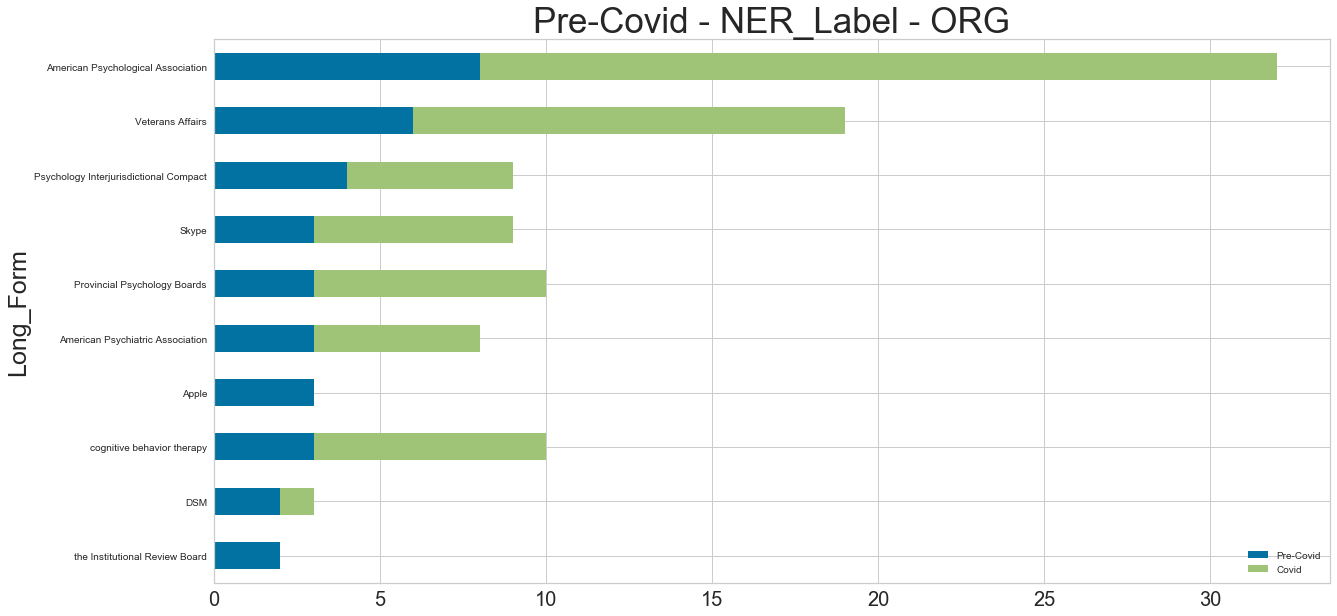

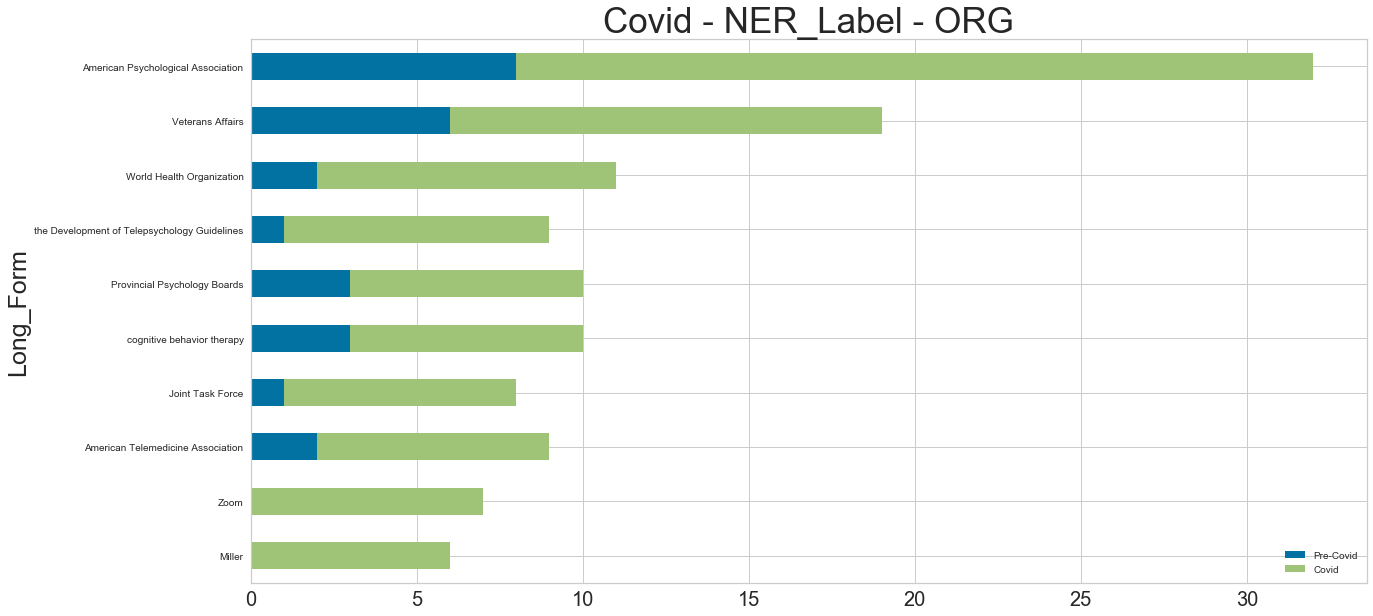

In [22]:
plot_compare(plot_by_time,"ORG")

# Take aways
<b> Same <b>
* Alot of change
* Many new names mentioned in the space
    
<b> Noticeable Movements <b>
    
<b> Rise <b>
    
* Chen is on the rise
* Wang is on the rise
* Cohen is on the rise
* Perle is on the rise
* Brooks is on the rise


    
<b> Most Notably Fall <b>
* Kramer is on the rise
* White is on the rise


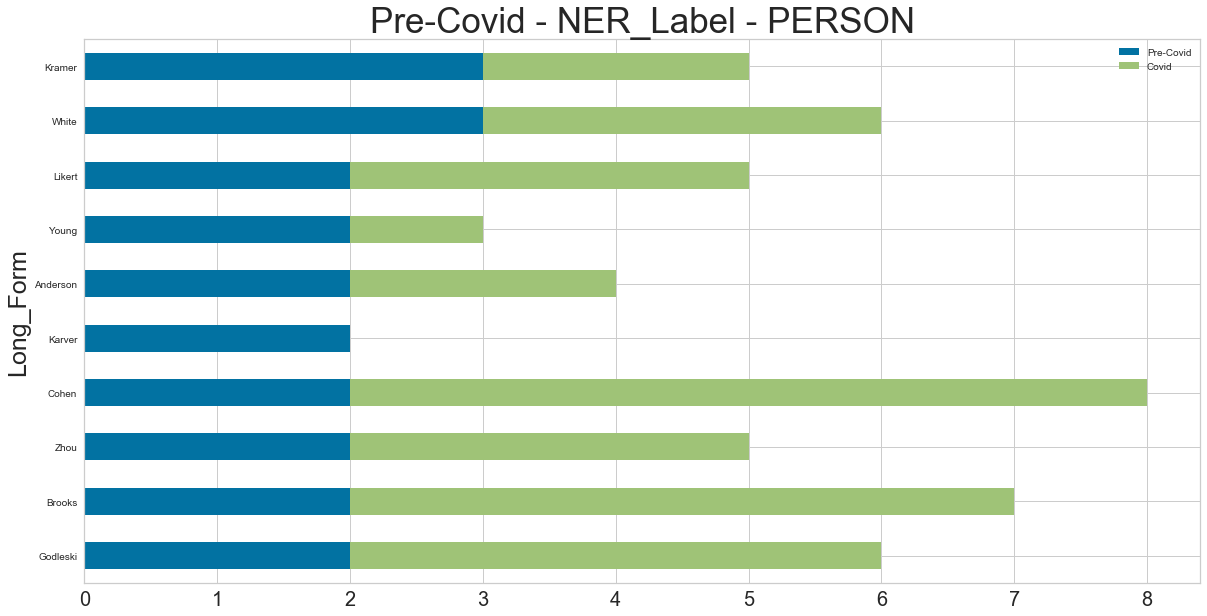

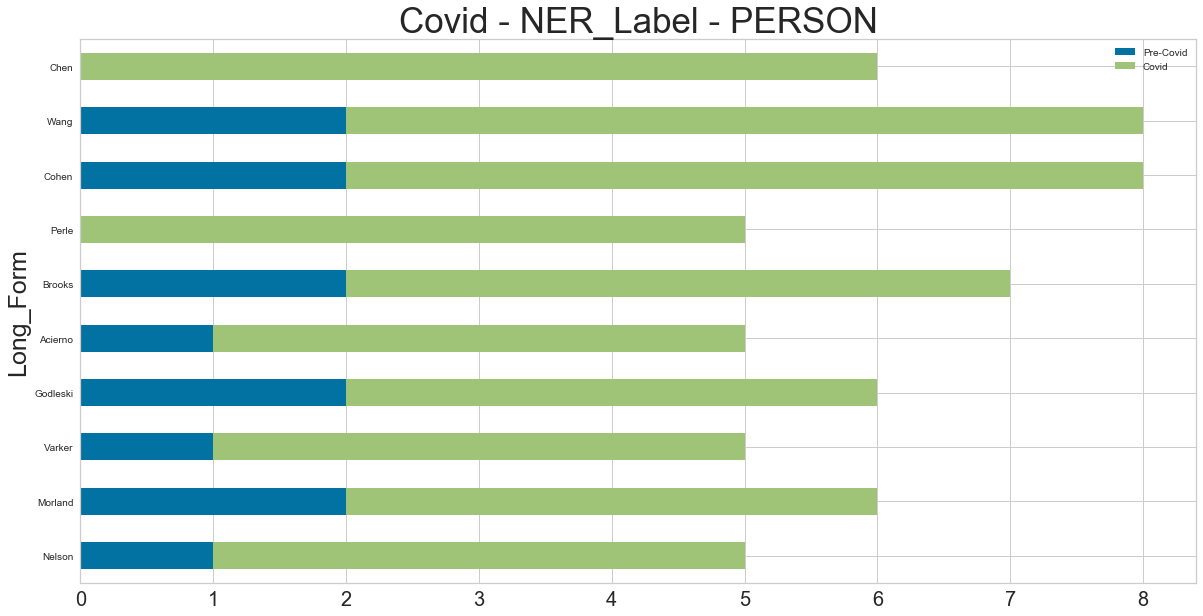

In [23]:
plot_compare(plot_by_time,"PERSON")